# DataScience bowl challenge

### Summary
The dataset to be treated in this challenge are cell pictures under very different conditions:
<ul>
    <li>Multiple tissues</li>
    <li>Brightfield microcospy</li>
    <li>Fluorescence microcospy</li>
</ul>
As the technical explanation states the great objective of this competition is to <b>build a very robust model in order to find cell nuclei in the above conditions and more.</b>
<br/>
#### Dataset
The training dataset is composed of 670 images with the above variations and also they come in different dimensions. Label images come in different images each for the manually segmented nuclei.
On the other side the testing dataset is comprised of 65 images.
<br/>
#### Issues found
<ul>
    <li>1. The size of the images is quite different in mamy cases. One solution may be to resize them to the largest or standardize the size</li>
    <li>2. Preprocessing steps will be useless as the conditions are expected to be different</li>
</ul>
<br/>
#### Approaches to deal with this competition
Most of the competitors are going to be using the well know model <b>U-NET</b> another options to try are the following:
<ul>
    <li>Encoder-Decoder</li>
    <li>SqueezNet</li>
    <li>Yolo</li>
</ul>
Finally, it seems more suitable to use <b>Reinforcement Learning Agents with computer vision techniques</b> acting on the input images giving them awards/punish tokens based on each label.
<br/>
#### Some useful scripts to start processing the data
<b><i>Useful packages</i></b>

In [1]:
import sys
import numpy as np
import tensorflow as tf
import random
import math
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import check_output
from glob import glob

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label, closing, opening, disk

/Users/dcamacho/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [221]:
# Set some parameters
NUCLEI_DATADIR = "{}{}".format(os.getenv("HOME"), '/raw-data/nuclei_segmentation/')
IMG_CHANNELS = 3
IMG_WIDTH, IMG_HEIGHT=256, 256

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

all_images = glob(os.path.join(NUCLEI_DATADIR, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
24768,/Users/dcamacho/raw-data/nuclei_segmentation/s...,4d4ebfcae4374165ea6ae7c7e18fd0ba5014c3c860ee24...,masks,train,stage1
24351,/Users/dcamacho/raw-data/nuclei_segmentation/s...,4bf6a5ec42032bb8dbbb10d25fdc5211b2fe1ce44b6e57...,masks,train,stage1


<b><i>Reading and loading images</i></b>

In [183]:
train_labels = pd.read_csv(os.path.join(NUCLEI_DATADIR,'{}_train_labels.csv'.format(img_df['Stage'][0])))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
7445,3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba3994...,"[339587, 7, 340104, 12, 340623, 14, 341141, 17..."
8068,449a9c32e53a37c8a86e01c199155c8da3958b631088e1...,"[117195, 8, 117713, 13, 118231, 16, 118750, 18..."
25923,dec1764c00e8b3c4bf1fc7a2fda341279218ff894186b0...,"[3285, 8, 3643, 14, 4001, 18, 4360, 20, 4719, ..."


In [180]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    

def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0

train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(train_img_df['images'].shape[0], 'train images processed')

train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
print(train_img_df['masks'].shape[0], 'mask images to processed')

670 train images to process
670 mask images to process
CPU times: user 36 s, sys: 6.24 s, total: 42.2 s
Wall time: 42.3 s


In [179]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]

test_img_df = pd.DataFrame(test_rows)
test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'test images processed')
test_img_df.sample(1)

65 images to process
CPU times: user 607 ms, sys: 110 ms, total: 717 ms
Wall time: 717 ms


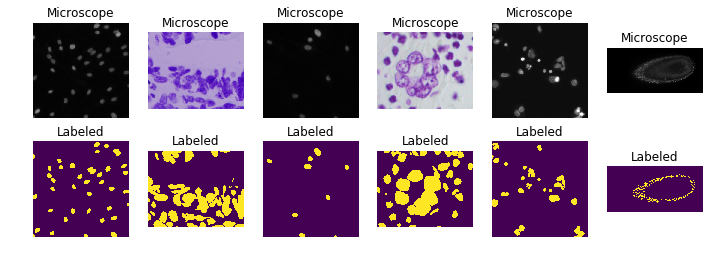

In [184]:
%matplotlib inline
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

### U-Net tensorflow model

In [262]:
def get_variable(name,shape):
    return tf.get_variable(name, shape, initializer = tf.contrib.layers.xavier_initializer())

def UNet(X):
    ### Unit 1 ###
    with tf.name_scope('Unit1'):
        W1_1 =   get_variable("W1_1", [3,3,3,16] )
        Z1 = tf.nn.conv2d(X,W1_1, strides = [1,1,1,1], padding = 'SAME')
        A1 = tf.nn.relu(Z1)
        W1_2 =   get_variable("W1_2", [3,3,16,16] )
        Z2 = tf.nn.conv2d(A1,W1_2, strides = [1,1,1,1], padding = 'SAME')
        A2 = tf.nn.relu(Z2) 
        P1 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    ### Unit 2 ###
    with tf.name_scope('Unit2'):
        W2_1 =   get_variable("W2_1", [3,3,16,32] )
        Z3 = tf.nn.conv2d(P1,W2_1, strides = [1,1,1,1], padding = 'SAME')
        A3 = tf.nn.relu(Z3)
        W2_2 =   get_variable("W2_2", [3,3,32,32] )
        Z4 = tf.nn.conv2d(A3,W2_2, strides = [1,1,1,1], padding = 'SAME')
        A4 = tf.nn.relu(Z4) 
        P2 = tf.nn.max_pool(A4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    ### Unit 3 ###
    with tf.name_scope('Unit3'):
        W3_1 =   get_variable("W3_1", [3,3,32,64] )
        Z5 = tf.nn.conv2d(P2,W3_1, strides = [1,1,1,1], padding = 'SAME')
        A5 = tf.nn.relu(Z5)
        W3_2 =   get_variable("W3_2", [3,3,64,64] )
        Z6 = tf.nn.conv2d(A5,W3_2, strides = [1,1,1,1], padding = 'SAME')
        A6 = tf.nn.relu(Z6) 
        P3 = tf.nn.max_pool(A6, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    ### Unit 4 ###
    with tf.name_scope('Unit4'):
        W4_1 =   get_variable("W4_1", [3,3,64,128] )
        Z7 = tf.nn.conv2d(P3,W4_1, strides = [1,1,1,1], padding = 'SAME')
        A7 = tf.nn.relu(Z7)
        W4_2 =   get_variable("W4_2", [3,3,128,128] )
        Z8 = tf.nn.conv2d(A7,W4_2, strides = [1,1,1,1], padding = 'SAME')
        A8 = tf.nn.relu(Z8) 
        P4 = tf.nn.max_pool(A8, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    ### Unit 5 ###
    with tf.name_scope('Unit5'):
        W5_1 =   get_variable("W5_1", [3,3,128,256] )
        Z9 = tf.nn.conv2d(P4,W5_1, strides = [1,1,1,1], padding = 'SAME')
        A9 = tf.nn.relu(Z9)
        W5_2 =   get_variable("W5_2", [3,3,256,256] )
        Z10 = tf.nn.conv2d(A9,W5_2, strides = [1,1,1,1], padding = 'SAME')
        A10 = tf.nn.relu(Z10) 
    ### Unit 6 ###
    with tf.name_scope('Unit6'):
        W6_1 =   get_variable("W6_1", [3,3,256,128] )
        U1 = tf.layers.conv2d_transpose(A10, filters = 128, kernel_size = 2, strides = 2, padding = 'SAME')
        U1 = tf.concat([U1, A8],3)
        W6_2 =   get_variable("W6_2", [3,3,128,128] )
        Z11 = tf.nn.conv2d(U1,W6_1, strides = [1,1,1,1], padding = 'SAME')
        A11 = tf.nn.relu(Z11)
        Z12 = tf.nn.conv2d(A11,W6_2, strides = [1,1,1,1], padding = 'SAME')
        A12 = tf.nn.relu(Z12)
    ### Unit 7 ###
    with tf.name_scope('Unit7'):
        W7_1 =   get_variable("W7_1", [3,3,128,64] )
        U2 = tf.layers.conv2d_transpose(A12, filters = 64, kernel_size = 2, strides = 2, padding = 'SAME')
        U2 = tf.concat([U2, A6],3)
        Z13 = tf.nn.conv2d(U2,W7_1, strides = [1,1,1,1], padding = 'SAME')
        A13 = tf.nn.relu(Z13)
        W7_2 =   get_variable("W7_2", [3,3,64,64] )
        Z14 = tf.nn.conv2d(A13,W7_2, strides = [1,1,1,1], padding = 'SAME')
        A14 = tf.nn.relu(Z14)
    ### Unit 8 ###
    with tf.name_scope('Unit8'):
        W8_1 =   get_variable("W8_1", [3,3,64,32] )
        U3 = tf.layers.conv2d_transpose(A14, filters = 32, kernel_size = 2, strides = 2, padding = 'SAME')
        U3 = tf.concat([U3, A4],3)
        Z15 = tf.nn.conv2d(U3,W8_1, strides = [1,1,1,1], padding = 'SAME')
        A15 = tf.nn.relu(Z15)
        W8_2 =   get_variable("W8_2", [3,3,32,32] )
        Z16 = tf.nn.conv2d(A15,W8_2, strides = [1,1,1,1], padding = 'SAME')
        A16 = tf.nn.relu(Z16)
    ### Unit 9 ###
    with tf.name_scope('Unit9'):
        W9_1 =   get_variable("W9_1", [3,3,32,16] )
        U4 = tf.layers.conv2d_transpose(A16, filters = 16, kernel_size = 2, strides = 2, padding = 'SAME')
        U4 = tf.concat([U4, A2],3)
        Z17 = tf.nn.conv2d(U4,W9_1, strides = [1,1,1,1], padding = 'SAME')
        A17 = tf.nn.relu(Z17)
        W9_2 =   get_variable("W9_2", [3,3,16,16] )
        Z18 = tf.nn.conv2d(A17,W9_2, strides = [1,1,1,1], padding = 'SAME')
        A18 = tf.nn.relu(Z18)
    ### Unit 10 ###
    with tf.name_scope('out_put'):
        W10 =    get_variable("W10", [1,1,16,1] )
        Z19 = tf.nn.conv2d(A18,W10, strides = [1,1,1,1], padding = 'SAME')
        A19 = tf.nn.sigmoid(Z19)
        Y_pred = A19
    return Y_pred

def loss_function(y_pred, y_true):
    cost = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true,y_pred))
    return cost

def mean_iou(y_pred,y_true):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return tf.keras.backend.mean(tf.keras.backend.stack(prec), axis=0)
  
def build_graph():
    with tf.Graph().as_default() as g:
        with tf.name_scope('input'):
            x_ = tf.placeholder(tf.float32, shape=(None, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
            y_ = tf.placeholder(tf.float32, shape=(None, IMG_WIDTH, IMG_HEIGHT, 1))
        y_pred = UNet(x_)
        with tf.name_scope('loss'):
            loss = loss_function(y_pred,y_)
        with tf.name_scope("metrics"):
            iou = mean_iou(y_pred,y_)
        model_dict = {'graph': g, 'inputs': [x_, y_],'Iou':iou,'Loss':loss, 'y_pred':y_pred}
    return model_dict

#### Support functions for calculation of rles and submission

In [106]:
def rle_encoding(x):
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [186]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']

match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

Matches: 360, Mismatches: 0, Accuracy: 100.0%


<b><i>Training the UNet model</i></b><br/> 

#### Useful functions for getting batches of images for stochastic training

In [254]:
def next_batch(batch_s, iters):
    global train_img_df
    if(iters == 0):
        train_img_df = train_img_df.sample(frac=1)
    count = batch_s * iters
    sub_train_img_df = train_img_df.iloc[count:(count + batch_s)]
    images = np.zeros((batch_s, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.dtype(float))
    labels = np.zeros((batch_s, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    i = 0
    for _, c_row in sub_train_img_df.iterrows():
        images[i] = resize(c_row['images'], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        labels[i] = np.expand_dims(resize(c_row['masks'], 
                                        (IMG_HEIGHT, IMG_WIDTH), 
                                        mode='constant', 
                                        preserve_range=True), axis=-1)
        i += 1
    return images, labels

In [265]:
unet_model = build_graph()
X, Y = next_batch(670, 1)
with tf.Session(graph=unet_model['graph']) as s:
    trainer = tf.train.RMSPropOptimizer(0.001).minimize(unet_model['Loss'])
    s.run(tf.global_variables_initializer())
    batch_count = 0
    display_count = 1
    for i in range(6700):
        # training on batches of 10 images with 10 mask images
        if(batch_count > 67):
            batch_count = 0    

        batch_X, batch_Y = next_batch(10, batch_count)
        
        batch_count += 1
        x_ = unet_model['inputs'][0]
        y_ = unet_model['inputs'][1]
        s.run(trainer, feed_dict={x_: batch_X, y_: batch_Y})

        if((i>0 and i % 335 == 0) or i==6699):
            cost = s.run(unet_model['Loss'], feed_dict={x_: batch_X, y_: batch_Y})
            s.run(tf.local_variables_initializer())
            iou = s.run(unet_model['Iou'], feed_dict={x_: X, y_: Y})
            print(str(display_count) + " training loss:", str(cost) + " IoU:", str(iou))
            display_count += 1
    print("Training finished!!... starting predictions")
    test_img_df['shape'] = test_img_df['images'].map(lambda x: x.shape)
    test_img_df['masks'] = test_img_df['images'].map(lambda x: 
                                                     s.run(unet_model['y_pred'], 
                                                           feed_dict={x_: np.expand_dims(resize(x,
                                                                                                (IMG_HEIGHT, IMG_WIDTH), 
                                                                                                mode='constant', 
                                                                                                preserve_range=True), 0)}))
    

1 training loss: 0.12667255 IoU: 0.0
2 training loss: 0.07484294 IoU: 0.0
3 training loss: 0.048744895 IoU: 0.0
4 training loss: 0.048721574 IoU: 0.0
5 training loss: 0.08363423 IoU: 0.0
6 training loss: 0.040380727 IoU: 0.0
7 training loss: 0.08586503 IoU: 0.0
8 training loss: 0.07479186 IoU: 0.0
9 training loss: 0.044701472 IoU: 0.0
10 training loss: 0.052163444 IoU: 0.0
11 training loss: 0.06466452 IoU: 0.0
12 training loss: 0.02520718 IoU: 0.0
13 training loss: 0.037102472 IoU: 0.0
14 training loss: 0.036740705 IoU: 0.0
15 training loss: 0.03663846 IoU: 0.0
16 training loss: 0.05456669 IoU: 0.0
17 training loss: 0.050591093 IoU: 0.0
18 training loss: 0.034368087 IoU: 0.0
19 training loss: 0.02658208 IoU: 0.0
20 training loss: 0.027345497 IoU: 0.0
Training finished!!... starting predictions


### Show some predictions

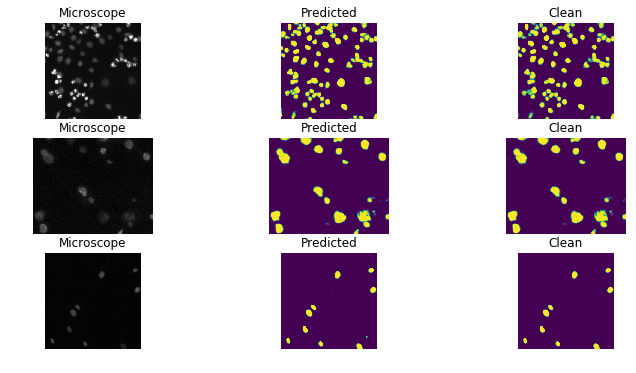

In [266]:
n_img = 3

def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))

fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    pred_mask = np.squeeze(d_row['masks'])
    resized_mask = resize(pred_mask, (d_row['shape'][0], d_row['shape'][1]), mode='constant', preserve_range=True)
    c_lab.imshow(resized_mask)
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(resized_mask))
    c_clean.axis('off')
    c_clean.set_title('Clean')

<b><i>RLE code to create the submissions</i></b>

In [267]:
rles = []
for _, d_row in test_img_df.iterrows():
    pred_mask = np.squeeze(d_row['masks'])
    resized_mask = resize(pred_mask, (d_row['shape'][0], d_row['shape'][1]), mode='constant', preserve_range=True)
    rles.append(prob_to_rles(clean_img(resized_mask)))

test_img_df = test_img_df.assign(rles=pd.Series(rles).values)

out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)

2572 regions found for 65 images
